# Bayes update

As explained in the notes, the Bayes update, or rule, tells us how to update our knowledge about something based on new information.

The coin toss example can provide a visual sequence of how our model, the probability $\theta$ of getting heads, changes as we keep tossing coins. If we start with a prior $P(\theta|I_0)$ and toss once, getting the face $s_1$, the posterior is $P(\theta|s_1I_0) = \frac{P(\theta|I_0)P(s_1|\theta I_0)}{Norm}$, where $Norm = \int_0^1 P(\theta|I_0)P(s_1|\theta I_0)$ is a normalization constant.
The Bayes rule tells replace our old prior by the posterior $P(\theta|I_0)\to P(\theta|s_1 I_0)=P(\theta|I_1)$, then with a next toss yielding $s_2$ we replace $P(\theta|I_1)\to P(\theta|s_2 I_1) = P(\theta|I_2)$ and so on.

If our model is $P(s=h|\theta I_0) = \theta$ and $P(s=t|\theta I_0) = 1 - \theta$, for $\theta \in [0,1]$, we can plot it after every coin toss and see how our belief of a biased coin changes as we go.
Notice that for $s=h$ we $P(\theta|s_1 I_0) = \frac{\theta P(\theta|I_0)}{Norm}$ and for $s=t$ we get $P(\theta|s_1 I_0) = \frac{(1-\theta)P(\theta|I_0)}{Norm}$.   

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
# scipy contains lots of useful algorithm for scitific computing, including probability distributions and
# statistical analysis, function and differential equation integration routines an much more.
# For this example I'm importing a few functions from the statistics and integration modules:
# Probability distributions:
from scipy.stats import beta, norm as normal, uniform, bernoulli, rv_continuous
# Definite integration for functions using Gaussian Quadrature
from scipy.integrate import quad

# Since we need to integrate a function after every coin toss, lets create a function that computes the
# right hand side of the Bayes update and returns the appropriate funtion given the result of a coin toss.
def bayes_update(s,prior):
    if s == 1:   # case s=h (heads)
        def likelihood_times_prior(θ):
            return θ*prior(θ)
    else:        # case s=t (tails)
        def likelihood_times_prior(θ):
            return (1-θ)*prior(θ)
    
    # integrate to get Norm.                        vvv this bit is to get only the result of the integral      
    normalization = quad(likelihood_times_prior,0,1)[0]
    
    # here we define the function that will replace our prior
    def posterior(θ):
        return likelihood_times_prior(θ)/normalization
    
    return posterior

To see how our prior affects our learning about the biasedness of the coin, we will use a few different prior functions, a completelly unbiased uniform distribution over $[0,1]$, a strongly biased beta distribution for a coin completelly biased towards one of the faces and a strongly biased normal distribution for a specific probability of flipping heads.

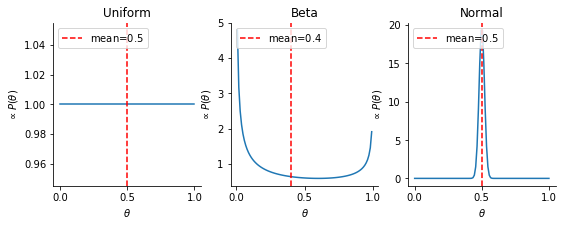

In [2]:
# basic use of scipy distribution objects: name_of_distribution(*parameters_of_dist).pdf(x) the
# probability density for point x.
# almost U-shaped Beta distribution 
beta_prior = beta(0.4,0.6).pdf
# Normal distribtution with strong bias towards a fair coin
normal_prior = normal(0.5,0.02).pdf
# Uniform unbiased prior
uniform_prior = uniform().pdf

# This function just plots a function p over the interval [0,1]
def plot_p_θ(p, ax=None, **kwargs):
    θs = np.linspace(0,1,100,endpoint=True)
    ps = p(θs)
    mean = quad(lambda x: x*p(x),0,1)[0]
    if ax is None:
        ax = plt.gca()
    ax.plot(θs, ps)
    ax.axvline(mean,color='r',linestyle='--',
               label='mean=${:.2}$'.format(mean))
    if 'title' in kwargs:
        ax.set_title(kwargs.pop('title'))
    for s in ('top','right'):
        ax.spines[s].set_visible(False)
    ax.legend(loc='upper left')
    ax.set_ylabel(r'$\propto P(\theta)$')
    ax.set_xlabel(r'$\theta$')
    return ax

# Lets look at the distributions 
fig, axs = plt.subplots(figsize=(9,3),ncols=3)
for ((n,p),ax) in zip({'Uniform':uniform_prior,'Beta':beta_prior,'Normal':normal_prior}.items(),axs):
    plot_p_θ(p,ax=ax, title=n)

The next functions are just to setup a figure for all the priors we want to see and the sample histogram for coin tosses in a sequential way.

In [3]:
def compare_plots(*,total,heads,real_θ,**priors):
    fig, axs = plt.subplots(ncols=4, figsize=(12,3))
    for ((d,p),ax) in zip(priors.items(),axs):
        plot_p_θ(p, ax=ax, title=d)
    for i in (1,2):
        axs[i].set_yticks([])
        axs[i].set_ylabel('')
        axs[i].spines['left'].set_visible(False)
    for s in ('right','top'):
        axs[-1].spines[s].set_visible(False)
    axs[-1].set_ylim(0,1)
    axs[-1].axhline(real_θ,color='r',linestyle='--',
                    label=r'real $\theta=$'+f'{real_θ:.3}')
    if total == 0: 
        fh, ft = 0, 0
    else:
        fh = heads/total
        ft = 1 - fh
    axs[-1].bar(['heads','tails'],[fh, ft])
    axs[-1].set_title('$'+f'N={total}'+'$')
    axs[-1].legend(loc='upper right')
    return fig

def multi_prior_updates(real_θ,**priors):
    toss = bernoulli(real_θ).rvs
    n, h = 0, 0
    while True:
        yield {'real_θ':real_θ,'heads':h,'total':n},priors
        s = toss()
        n += 1
        h += s
        for (d,p) in priors.items():
            priors[d] = bayes_update(s,p)

In [4]:
figs = [{**sd,**pd}
        for (n,(sd,pd)) in zip(range(61),
                               multi_prior_updates(0.7,
                                                   Uniform=uniform_prior,
                                                   Beta=beta_prior,
                                                   Normal=normal_prior)) 
        if n % 20 == 0]

/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


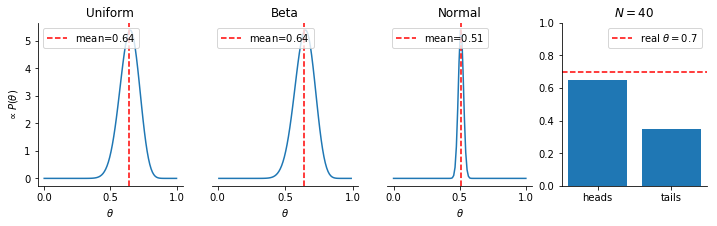

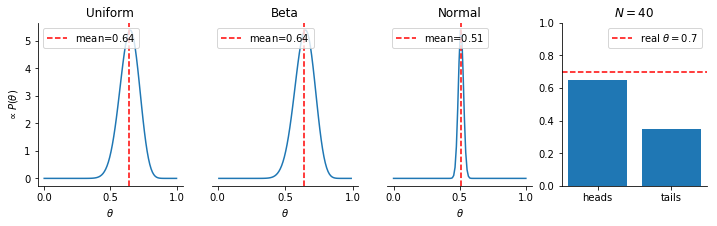

In [5]:
n = 2
compare_plots(**figs[n])

## Exercise

Lets do the Bayesian version of the line fit exercise from Python tutorial notebook.

Consider we have a set of points $\{(x_1,y_1),(x_2,y_2)\dots,(x_n,y_n)\}$ for which we theorize that $y = ax + b$. We can use probability infer the paramenters $a$ and $b$, pretty much as we did above with the probability $\theta$ of getting heads in a coin toss.
If we consider possible mesurament errors, we expect the value of any given $y_i$ to be around $ax_i + b$, so lets choose the likelihood of observing $(x,y)$ given the model to be a Normal distribution for $y-ax-b$ with mean $0$ and variance $1$: $L(y-ax-b|a,b,I) = \frac{1}{\sqrt{2\pi}}\mathrm{e}^{-{1\over2}(y-ax-b)^2}$.

Lets choose a Normal distribution as prior for $a$ and $b$, so $Q(a,b|I) = N(a|\hat{a},v_a)N(b|\hat{b},v_b)$ 
With the likehood $L$ we can update our prior $Q$ to the posterior $P = \frac{QL}{Norm}$ and get an estimate for the parameters $a$ and $b$. For this case, lets use the posterior mean as an estimate, so $\hat{a} = \int aQ(a,b|I)\mathrm{d}a$ and $\hat{b} = \int bQ(a,b|I) \mathrm{d}b$.
We can do this *online*, by using each point in the dataset once and sequentilly, or *offline*, using the whole dataset once.

Your tasks are:
  1. Use the Probability rules to write the likelihood for the whole dataset
  2. Choose the initial values of the *hyperparameters* $\hat{a},v_a,\hat{b},v_b$ so that the prior is not frozen as in the coin toss example with a normal prior.
  3. Write a Python function to update the prior to a posterior in this problem.
  4. Use the function `plot_p_and_line` to plot the distribution $P$ and the fitted line at each step in the online scenario and for the final result in the offline scneario.
  
The data set to be used is in the variable `data`.

In [16]:
from scipy.integrate import dblquad
# just a shorthand for infinity
oo = np.infty

np.random.seed(42)
x = np.linspace(-5,5,11,endpoint=True)
x += 0.5*np.random.randn(x.shape[0])
y = 3.5*x - 1 + np.random.randn(x.shape[0])

# here the dataset is structured as two array instead of a list 
# of pairs
data = (x,y)

def plot_p_and_line(p, hat_a, hat_b, dataset):
    fig, axs = plt.subplots(ncols=2,figsize=(6,3)) 
    z = np.linspace(-5, 5, 200, endpoint=True)
    pab = p(z,z[:,None])
    axs[1].plot(z,hat_a*z+hat_b,c='r',label='fit')
    axs[1].scatter(*dataset, label='data')
    for s in ('top','right'):
        axs[1].spines[s].set_visible(False)
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$y$')
    for (s,e) in axs[0].spines.items():
        e.set_visible(False)
    axs[0].pcolormesh(z,z[:,None],pab,cmap='magma')
    axs[0].axvline(hat_a,color='b',linestyle='--',lw=1)
    axs[0].axhline(hat_b,color='b',linestyle='--',lw=1)
    axs[0].set_xlabel(r'$a$')
    axs[0].set_ylabel(r'$b$')
    return fig

# call this function to get the prior
def init_prior(hat_a,v_a,hat_b,v_b):
    na, nb = normal(hat_a,v_a), normal(hat_b,v_b)
    def prior(a,b):
        return na.pdf(a)*nb.pdf(b)
    return prior

# call this function to get the mean of a distribution in this problem
def means(p):
    hat_a = dblquad(lambda a,b: a*p(a,b),-oo,oo, lambda x: -oo, lambda x: oo)[0]
    hat_b = dblquad(lambda a,b: b*p(a,b),-oo,oo, lambda x: -oo, lambda x: oo)[0]
    return hat_a, hat_b

# this is the likelihood for each point of the dataset
Lp = normal(0,1).pdf
def point_likelihood(x,y,a,b):
    return Lp(y-a*x-b)

In [70]:
q = init_prior(0,5,0,5)

In [71]:
means(q)

(0.0, 0.0)

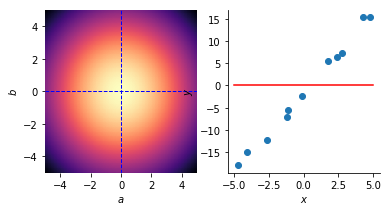

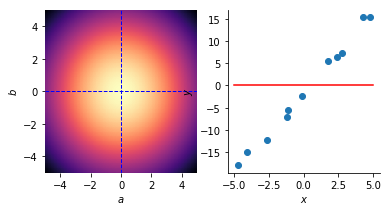

In [72]:
plot_p_and_line(q,0,0,data)

In [96]:
def line_bayes(x,y,prior,likelihood):
    def likelihood_times_prior(a,b):
        return prior(a,b)*likelihood(x,y,a,b)
    
    integration_bounds = (-oo, oo, lambda x: -oo, lambda x: oo)
    
    # duo to numerical instalbilities its is necessary to do this twice, which is very dumb, 
    # but we are stuck with it for now
    normalization,error = dblquad(likelihood_times_prior, *integration_bounds)
    def almost_posterior(a,b):
        return likelihood_times_prior(a,b)/normalization
    
    normalization2,error = dblquad(almost_posterior, *integration_bounds)
    def posterior(a,b):
        return almost_posterior(a,b)/normalization2
    
    return posterior

In [97]:
def data_likelihood(x,y,a,b):
    l = 1.0
    for (xi,yi) in zip(x,y):
        l *= point_likelihood(xi,yi,a,b)
    return l

In [98]:
p = line_bayes(x,y,q,data_likelihood)

In [99]:
p(3.5,-1)

0.6159769728481167

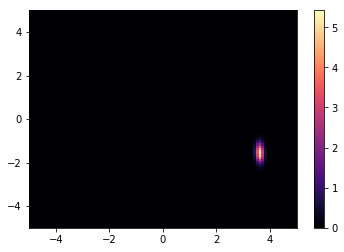

In [100]:
zz = np.linspace(-5,5,101,endpoint=True)
plt.pcolormesh(zz,zz,p(zz,zz[:,None]),cmap='magma')
plt.colorbar()

In [101]:
hat_a, hat_b = means(p)

In [102]:
hat_a, hat_b

(3.593026111040239, -1.5751780422507813)

In [103]:
hat_a/abs(hat_b), hat_b/abs(hat_b)

(2.28102856608269, -1.0)

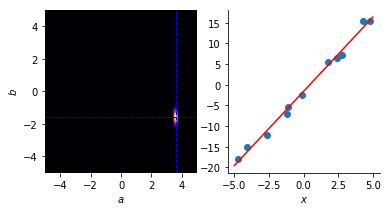

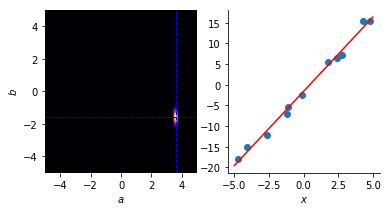

In [104]:
plot_p_and_line(p, hat_a, hat_b, data)